In [1]:
%pip install torchvision

import sys
import os
sys.path.append(os.path.abspath('../src'))

import importlib
import utils
importlib.reload(utils)

  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1

<module 'utils' from '/mnt/batch/tasks/shared/LS_root/mounts/clusters/c1-eloise/code/Users/iam.hsiang/Diagnostic_C_Biomarker/src/utils.py'>

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_data, preprocess_data, custom_scorer, plot_confusion_matrix

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.2):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [27]:
# Function to train the model for one epoch
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # Handle both binary and multi-class scenarios
    unique_labels = np.unique(all_labels)
    if len(unique_labels) > 2:
        # Multi-class
        auc_roc = roc_auc_score(label_binarize(all_labels, classes=unique_labels), all_probs, multi_class='ovr', average='macro')
    else:
        # Binary
        auc_roc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])
    
    return total_loss / len(data_loader), accuracy, auc_roc, all_predictions, all_labels

In [28]:
# Function to train and evaluate the neural network with hyperparameter tuning
def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train)
    y_train_tensor = torch.LongTensor(y_train.values if hasattr(y_train, 'values') else y_train)
    X_test_tensor = torch.FloatTensor(X_test.values if hasattr(X_test, 'values') else X_test)
    y_test_tensor = torch.LongTensor(y_test.values if hasattr(y_test, 'values') else y_test)

    # Define hyperparameter ranges for tuning
    learning_rates = [0.001, 0.01, 0.1]
    hidden_sizes_options = [[32, 16], [64, 32], [128, 64]]
    batch_sizes = [32, 64, 128]
    num_epochs = 100

    best_val_accuracy = 0
    best_hyperparameters = {}
    best_model = None

    # Hyperparameter tuning loop
    for lr in learning_rates:
        for hidden_sizes in hidden_sizes_options:
            for batch_size in batch_sizes:
                # Create DataLoader with current batch size
                train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
                val_loader = DataLoader(val_dataset, batch_size=batch_size)

                # Initialize the model with current hidden sizes
                input_size = X_train.shape[1]
                output_size = len(np.unique(y_train))
                model = NeuralNetwork(input_size, hidden_sizes, output_size)

                # Define loss function and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)

                for epoch in range(num_epochs):
                    train_model(model, train_loader, criterion, optimizer, device)
                    _, train_accuracy, train_auc, _, _ = evaluate_model(model, train_loader, criterion, device)
                    val_loss, val_accuracy, val_auc, _, _ = evaluate_model(model, val_loader, criterion, device)
                    
                    # # Print progress every 10 epochs
                    # if (epoch + 1) % 10 == 0:
                    #     print(f"Epoch {epoch+1}/{num_epochs}, LR: {lr}, Hidden Sizes: {hidden_sizes}, Batch Size: {batch_size}")
                    #     print(f"Train Acc: {train_accuracy:.4f}, Train AUC: {train_auc:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

                # Update best model if necessary
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_hyperparameters = {
                        'learning_rate': lr,
                        'hidden_sizes': hidden_sizes,
                        'batch_size': batch_size
                    }
                    best_model = model

    print("Best hyperparameters:", best_hyperparameters)
    print("Best validation accuracy:", best_val_accuracy)
    
    # Final evaluation of the best model
    _, _, _, y_pred, y_true = evaluate_model(best_model, val_loader, criterion, device)

    # Handle both binary and multi-class scenarios
    unique_labels = np.unique(y_true)
    if len(unique_labels) > 2:
        # Multi-class
        y_pred_proba = torch.softmax(best_model(X_test_tensor.to(device)), dim=1).cpu().detach().numpy()
        auc_roc = roc_auc_score(label_binarize(y_true, classes=unique_labels), y_pred_proba, multi_class='ovr', average='macro')
    else:
        # Binary
        y_pred_proba = torch.softmax(best_model(X_test_tensor.to(device)), dim=1)[:, 1].cpu().detach().numpy()
        auc_roc = roc_auc_score(y_true, y_pred_proba)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'auc_roc': auc_roc,
        'classification_report': classification_report(y_true, y_pred)
    }

    return best_model, metrics

In [29]:
# Load data for each feature set
feature_sets = ['../Data/Features/Random_Forest.csv', '../Data/Features/RF_MI_Union.csv', 
                '../Data/Features/RF_MI_Intersection.csv',
                '../Data/Features/NSCLC_biomarkers_de_analysis.csv', 
                '../Data/Features/NSCLC_biomarkers_50_de_analysis.csv',
                '../Data/Features/RF_MI_DE_Union.csv',
                '../Data/Features/MI_DE_Intersection.csv',
                '../Data/Features/RF_DE_Intersection.csv',
               ]

expression_path = '../Data/Processed/NSCLC_expression_model_training.csv'
labels_path = '../Data/Processed/NSCLC_labels_model_training.csv'

Processing feature set: ../Data/Features/Random_Forest.csv
Best hyperparameters: {'learning_rate': 0.001, 'hidden_sizes': [64, 32], 'batch_size': 128}
Best validation accuracy: 0.9594594594594594

Final model performance:
Accuracy: 0.9595
AUC-ROC: 0.9952

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       0.95      0.96      0.96       100
           2       1.00      1.00      1.00        14

    accuracy                           0.96       222
   macro avg       0.97      0.97      0.97       222
weighted avg       0.96      0.96      0.96       222



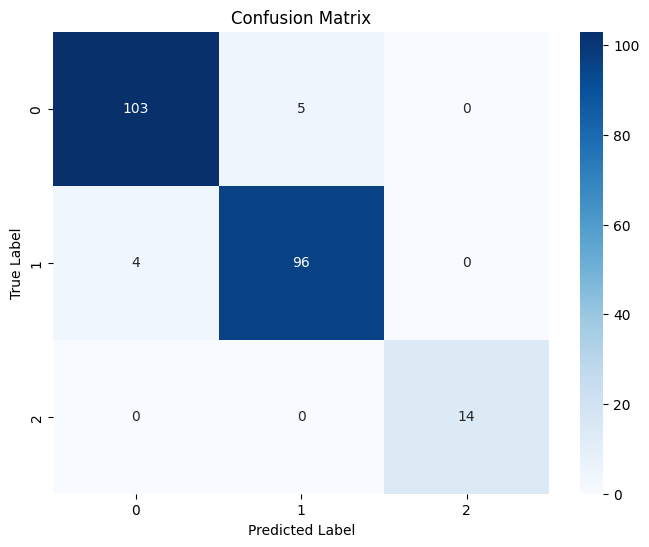

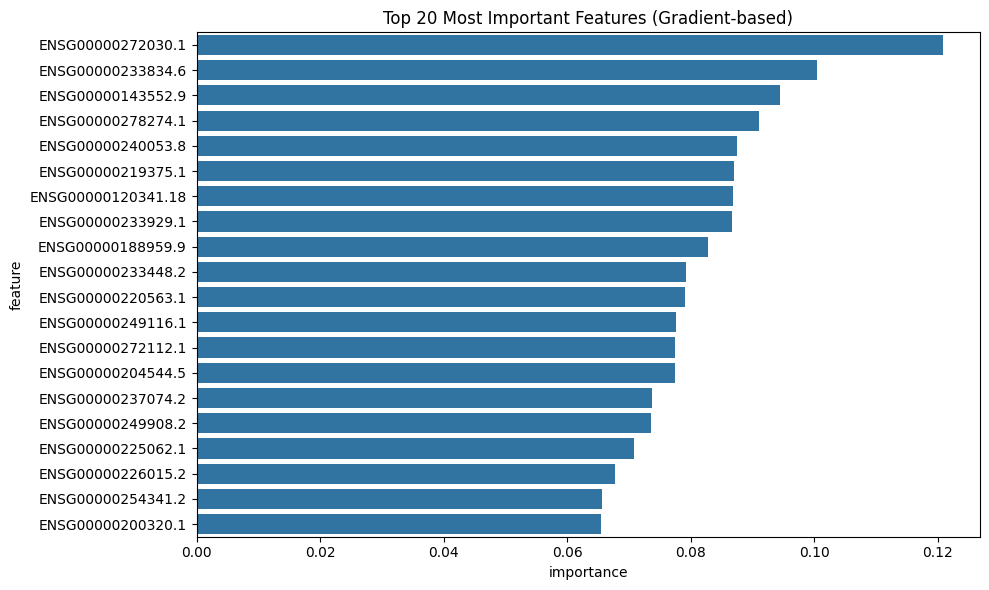

Processing feature set: ../Data/Features/RF_MI_Union.csv
Best hyperparameters: {'learning_rate': 0.1, 'hidden_sizes': [128, 64], 'batch_size': 128}
Best validation accuracy: 0.972972972972973

Final model performance:
Accuracy: 0.9730
AUC-ROC: 0.9824

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       108
           1       1.00      0.94      0.97       100
           2       1.00      1.00      1.00        14

    accuracy                           0.97       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.97      0.97      0.97       222



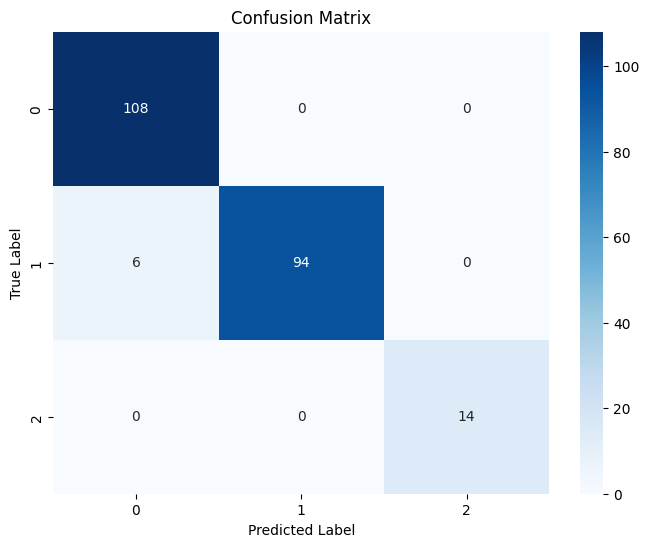

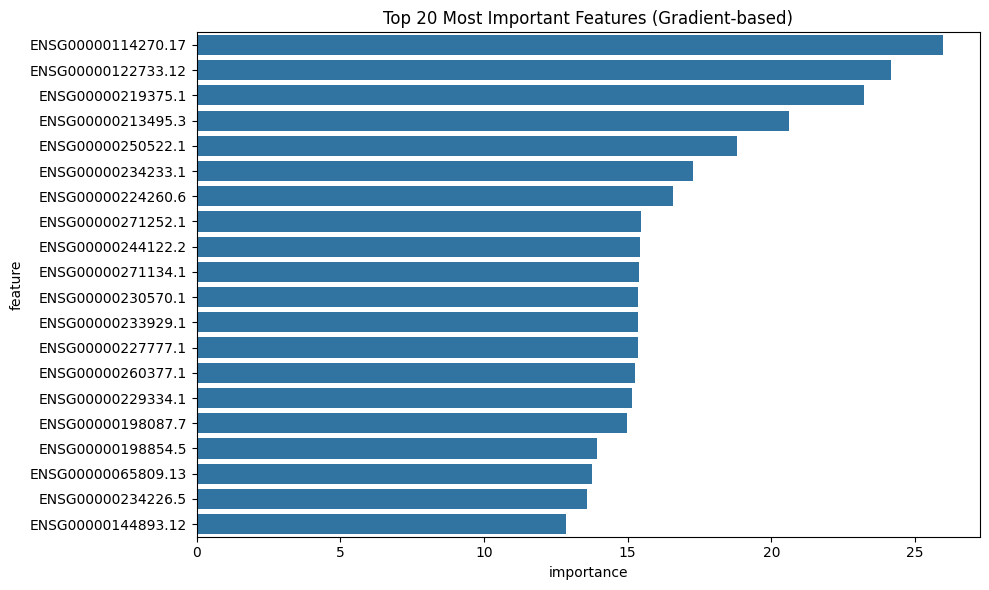

Processing feature set: ../Data/Features/RF_MI_Intersection.csv
Best hyperparameters: {'learning_rate': 0.001, 'hidden_sizes': [32, 16], 'batch_size': 128}
Best validation accuracy: 0.9684684684684685

Final model performance:
Accuracy: 0.9685
AUC-ROC: 0.9976

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.97      0.96      0.96       100
           2       1.00      1.00      1.00        14

    accuracy                           0.97       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.97      0.97      0.97       222



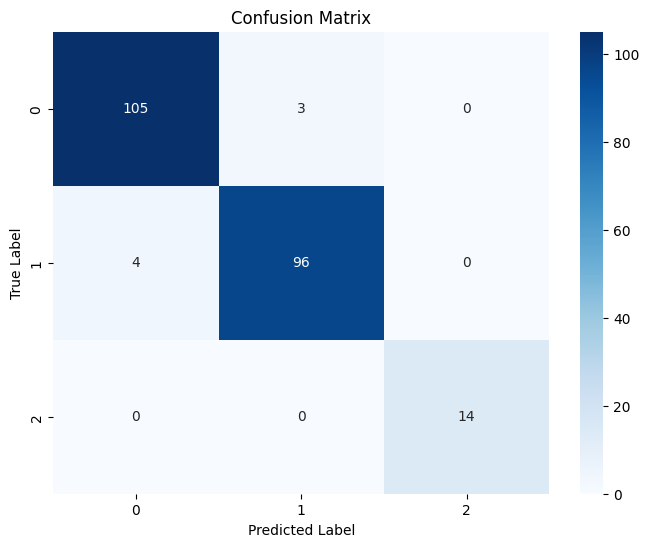

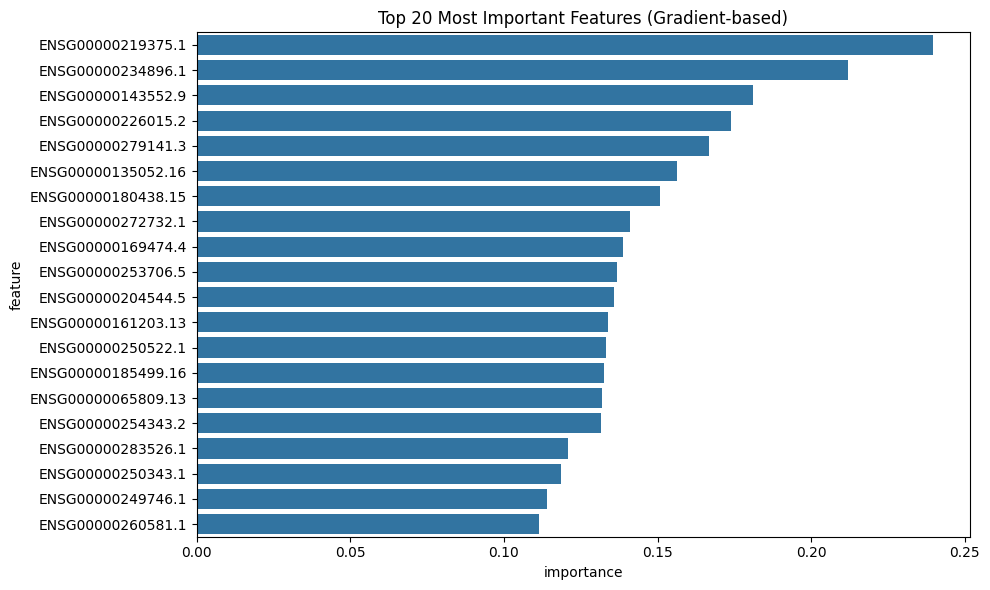

Processing feature set: ../Data/Features/NSCLC_biomarkers_de_analysis.csv
Best hyperparameters: {'learning_rate': 0.01, 'hidden_sizes': [32, 16], 'batch_size': 128}
Best validation accuracy: 0.9324324324324325

Final model performance:
Accuracy: 0.9324
AUC-ROC: 0.9822

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.93      0.93      0.93       100
           2       0.93      1.00      0.97        14

    accuracy                           0.93       222
   macro avg       0.93      0.95      0.94       222
weighted avg       0.93      0.93      0.93       222



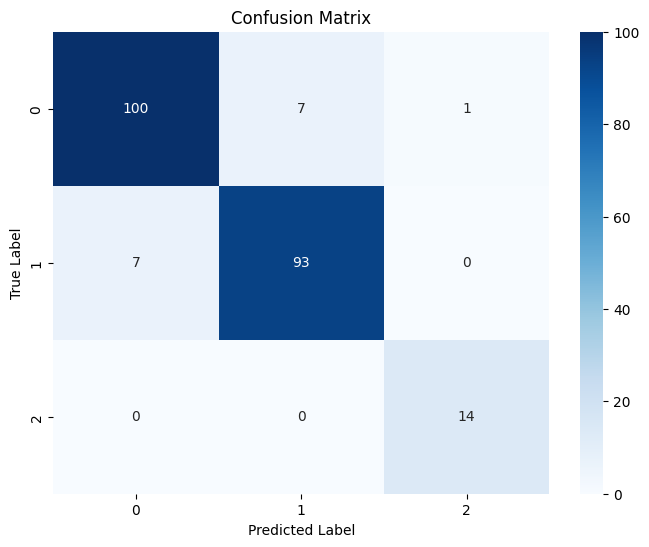

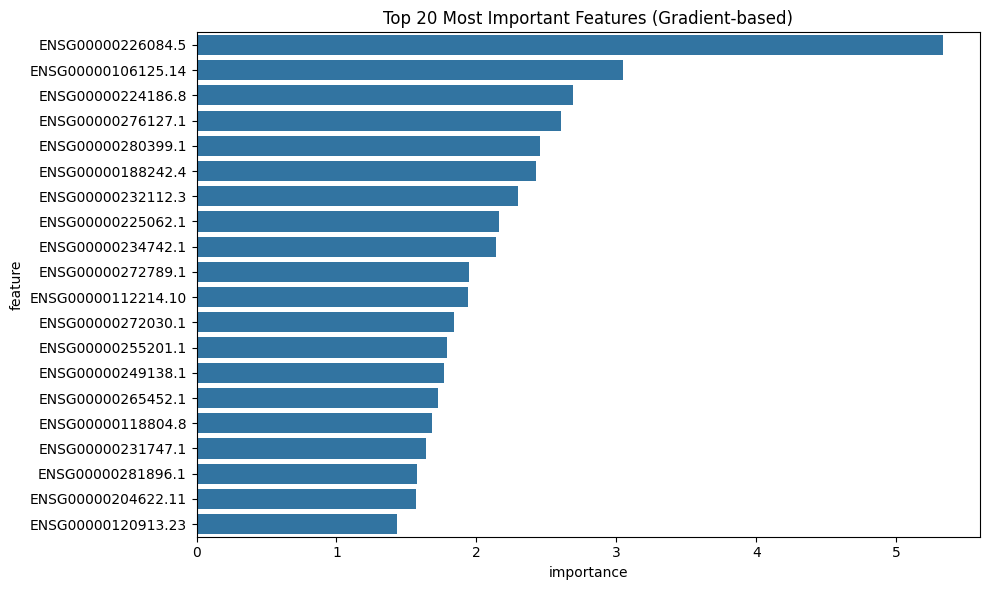

Processing feature set: ../Data/Features/NSCLC_biomarkers_50_de_analysis.csv
Best hyperparameters: {'learning_rate': 0.001, 'hidden_sizes': [32, 16], 'batch_size': 128}
Best validation accuracy: 0.9009009009009009

Final model performance:
Accuracy: 0.9009
AUC-ROC: 0.9766

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       108
           1       0.88      0.90      0.89       100
           2       1.00      1.00      1.00        14

    accuracy                           0.90       222
   macro avg       0.93      0.93      0.93       222
weighted avg       0.90      0.90      0.90       222



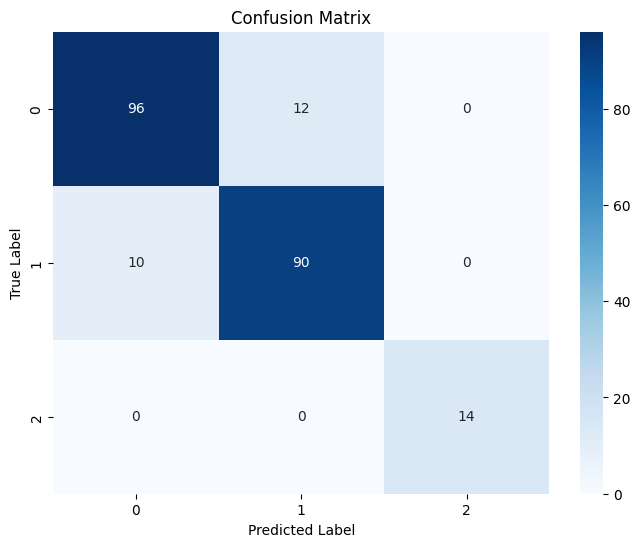

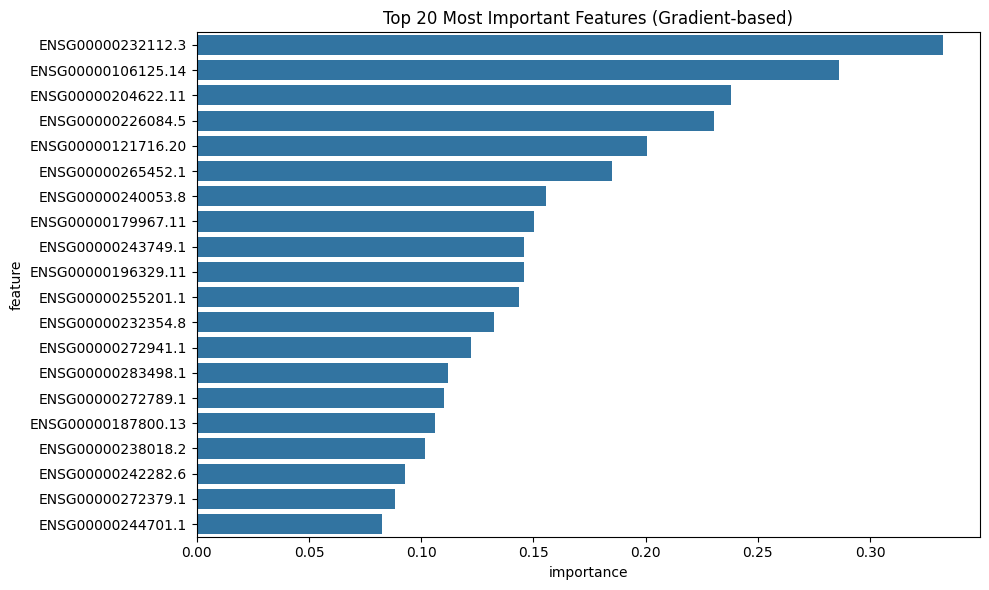

Processing feature set: ../Data/Features/RF_MI_DE_Union.csv
Best hyperparameters: {'learning_rate': 0.01, 'hidden_sizes': [32, 16], 'batch_size': 32}
Best validation accuracy: 0.8738738738738738

Final model performance:
Accuracy: 0.8739
AUC-ROC: 0.9585

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       108
           1       0.84      0.89      0.86       100
           2       1.00      1.00      1.00        14

    accuracy                           0.87       222
   macro avg       0.91      0.91      0.91       222
weighted avg       0.88      0.87      0.87       222



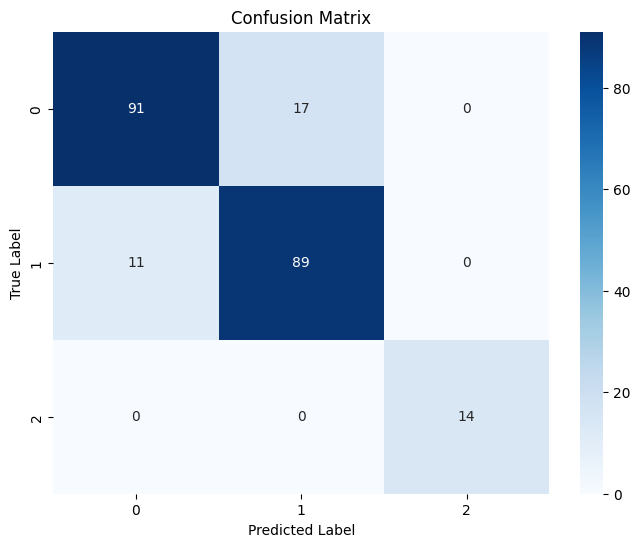

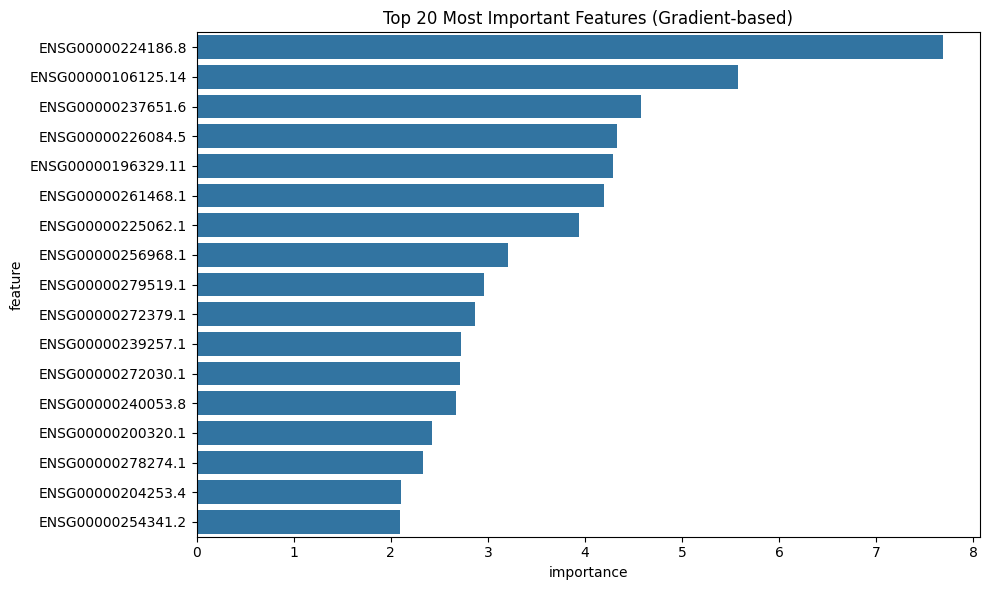

Processing feature set: ../Data/Features/MI_DE_Intersection.csv
Best hyperparameters: {'learning_rate': 0.01, 'hidden_sizes': [32, 16], 'batch_size': 32}
Best validation accuracy: 0.8828828828828829

Final model performance:
Accuracy: 0.8829
AUC-ROC: 0.9618

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       108
           1       0.83      0.93      0.88       100
           2       1.00      1.00      1.00        14

    accuracy                           0.88       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.89      0.88      0.88       222



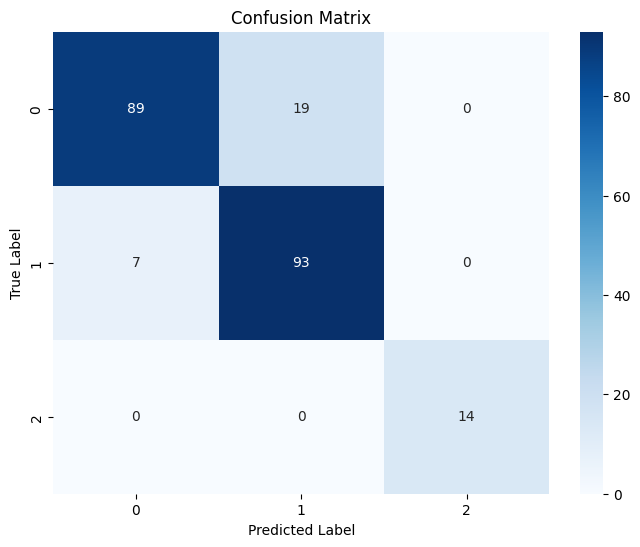

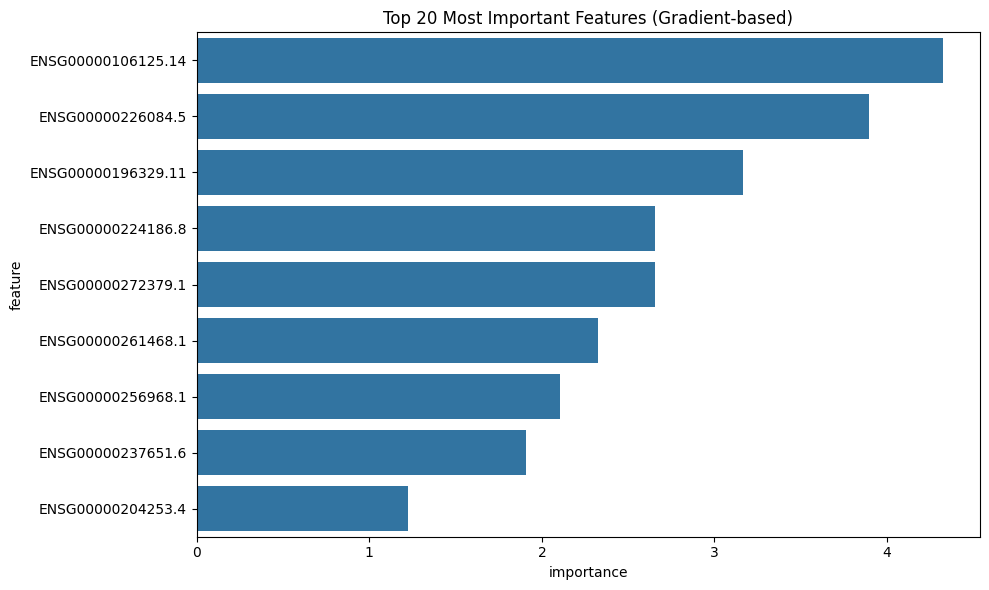

Processing feature set: ../Data/Features/RF_DE_Intersection.csv
Best hyperparameters: {'learning_rate': 0.01, 'hidden_sizes': [32, 16], 'batch_size': 64}
Best validation accuracy: 0.5990990990990991

Final model performance:
Accuracy: 0.5991
AUC-ROC: 0.7600

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.79      0.66       108
           1       0.60      0.34      0.43       100
           2       1.00      1.00      1.00        14

    accuracy                           0.60       222
   macro avg       0.72      0.71      0.70       222
weighted avg       0.61      0.60      0.58       222



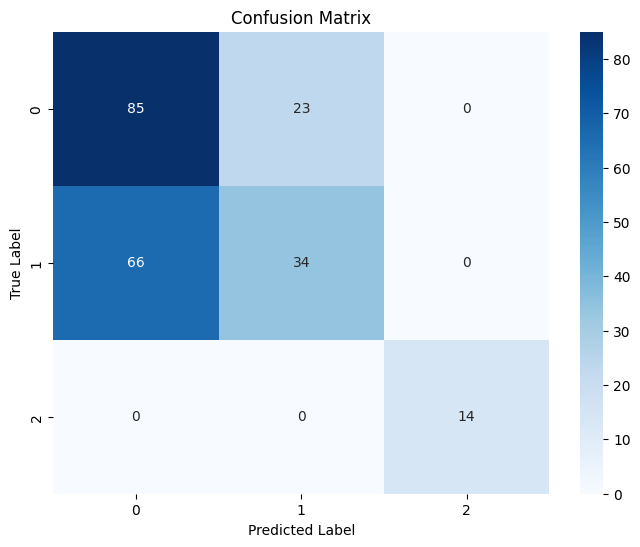

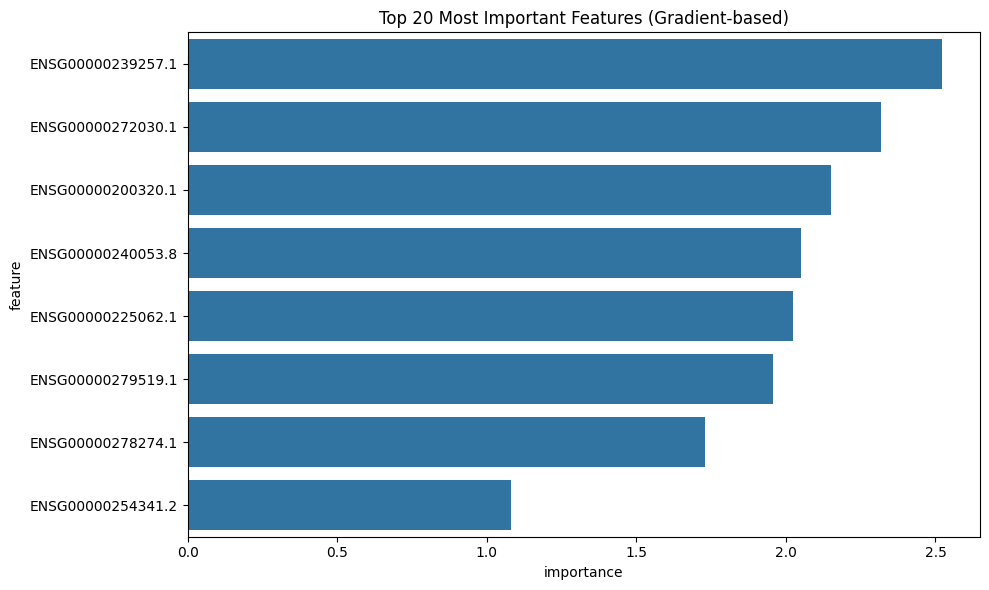

In [30]:
# Main execution
for feature_set in feature_sets:
    print(f"Processing feature set: {feature_set}")
    
    # Load and preprocess data
    X, y = load_data(expression_path, labels_path, feature_set)
    X_train, X_test, y_train, y_test = preprocess_data(X, y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    # Train and evaluate the model with hyperparameter tuning
    best_model, metrics = train_and_evaluate_nn(X_train_scaled, X_test_scaled, y_train, y_test)
    
    print("\nFinal model performance:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
    print("\nClassification Report:\n", metrics['classification_report'])
    
    # Plot confusion matrix
    y_pred = best_model(torch.FloatTensor(X_test_scaled.values)).argmax(dim=1).numpy()
    plot_confusion_matrix(y_test, y_pred)
    
    # Feature importance (using gradient-based method)
    best_model.eval()
    X_test_tensor = torch.FloatTensor(X_test_scaled.values).requires_grad_()
    output = best_model(X_test_tensor)
    output.sum().backward()
    feature_importance = X_test_tensor.grad.abs().mean(0).numpy()
    
    # Plot feature importance
    feature_importance_df = pd.DataFrame({
        'feature': X_test_scaled.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Most Important Features (Gradient-based)')
    plt.tight_layout()
    plt.show()
    
    # Uncomment the following lines if you want to save the model and feature importance
    # torch.save(best_model.state_dict(), f'best_nn_model_{feature_set}.pth')
    # feature_importance_df.to_csv(f'feature_importance_nn_{feature_set}.csv', index=False)
    
    # print(f"Model and feature importance for {feature_set} have been saved.")
    # print("\n" + "="*50 + "\n")